##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quickstart

This code tutorial shows how to estimate a 1-RDM and perform variational optimization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/hfvqe/quickstart"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [3]:
import numpy as np
import cirq

from recirq.hfvqe.gradient_hf import rhf_func_generator
from recirq.hfvqe.opdm_functionals import OpdmFunctional
from recirq.hfvqe.analysis import (
    compute_opdm, mcweeny_purification,
    resample_opdm, fidelity_witness,
    fidelity)
from recirq.hfvqe.third_party.higham import fixed_trace_positive_projection
from recirq.hfvqe.molecular_example import make_h6_1_3

## Set up the experiment

Generate the input files, set up quantum resources, and set up the OpdmFunctional to make measurements. 

In [4]:
rhf_objective, molecule, parameters, obi, tbi = make_h6_1_3()
ansatz, energy, gradient = rhf_func_generator(rhf_objective)

# settings for quantum resources
qubits = [cirq.GridQubit(0, x) for x in range(molecule.n_orbitals)]
sampler = cirq.Simulator(dtype=np.complex128)  # this can be a QuantumEngine

# OpdmFunctional contains an interface for running experiments
opdm_func = OpdmFunctional(qubits=qubits,
                           sampler=sampler,
                           constant=molecule.nuclear_repulsion,
                           one_body_integrals=obi,
                           two_body_integrals=tbi,
                           # only simulate spin-up electrons:
                           num_electrons=molecule.n_electrons // 2,
                           clean_xxyy=True,
                           purification=True
                           )

Optimization terminated successfully.
         Current function value: -2.924060
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


The displayed text is the output of the gradient based restricted Hartree-Fock.  We define the gradient in `rhf_objective` and use the conjugate-gradient optimizer to optimize the basis rotation parameters.  This is equivalent to doing Hartree-Fock theory from the canonical transformation perspective.

## Estimate Quantities

Next, we will do the following:

1. Do measurements for a given set of parameters

2. Compute 1-RDM, variances, and purification

3. Compute energy, fidelities, and errorbars

In [5]:
# 1.
# default to 250_000 shots for each circuit.
# 7 circuits total, printed for your viewing pleasure
# return value is a dictionary with circuit results for each permutation
measurement_data = opdm_func.calculate_data(parameters)

# 2.
opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
opdm_pure = mcweeny_purification(opdm)

# 3.
raw_energies = []
raw_fidelity_witness = []
purified_eneriges = []
purified_fidelity_witness = []
purified_fidelity = []
true_unitary = ansatz(parameters)
nocc = molecule.n_electrons // 2
nvirt = molecule.n_orbitals - nocc
initial_fock_state = [1] * nocc + [0] * nvirt

# 1000 repetitions of the measurement
for _ in range(1000):  
    new_opdm = resample_opdm(opdm, var_dict)
    raw_energies.append(opdm_func.energy_from_opdm(new_opdm))
    raw_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm)
    )
    # fix positivity and trace of sampled 1-RDM if strictly outside
    # feasible set
    w, v = np.linalg.eigh(new_opdm)
    if len(np.where(w < 0)[0]) > 0:
        new_opdm = fixed_trace_positive_projection(new_opdm, nocc)

    new_opdm_pure = mcweeny_purification(new_opdm)
    purified_eneriges.append(opdm_func.energy_from_opdm(new_opdm_pure))
    purified_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm_pure)
    )
    purified_fidelity.append(
        fidelity(target_unitary=true_unitary,
                 measured_opdm=new_opdm_pure)
    )
print("Canonical Hartree-Fock energy ", molecule.hf_energy)
print("True energy ", energy(parameters))
print("Raw energy ", opdm_func.energy_from_opdm(opdm),
      "+- ", np.std(raw_energies))
print("Raw fidelity witness ", np.mean(raw_fidelity_witness).real,
      "+- ", np.std(raw_fidelity_witness))
print("purified energy ", opdm_func.energy_from_opdm(opdm_pure),
      "+- ", np.std(purified_eneriges))
print("Purified fidelity witness ", np.mean(purified_fidelity_witness).real,
      "+- ", np.std(purified_fidelity_witness))
print("Purified fidelity ", np.mean(purified_fidelity).real,
      "+- ", np.std(purified_fidelity))

/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)


/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)


/tmpfs/tmp/ipykernel_8722/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)


Canonical Hartree-Fock energy  -2.9240604849733085
True energy  -2.924060484972228
Raw energy  -2.9213044931760517 +-  0.0015177972177468448
Raw fidelity witness  0.997033277160794 +-  0.0020815856454034325
purified energy  -2.9240559215724597 +-  5.5249068450963004e-06
Purified fidelity witness  0.999978892040198 +-  8.959420956931912e-06
Purified fidelity  0.999989446541326 +-  4.479680869499371e-06


This prints out the various energies estimated from the 1-RDM along with error bars.  Generated from resampling the 1-RDM based on the estimated covariance.

## Optimization

We use the sampling functionality to variationally relax the parameters of
my ansatz such that the energy is decreased.

For this we will need the augmented Hessian optimizer

The optimizerer code we have takes:
rhf_objective object, initial parameters,
a function that takes a n x n unitary and returns an opdm
maximum iterations,
hassian_update which indicates how much of the hessian to use
rtol which is the gradient stopping condition.

A natural thing that we will want to save is the variance dictionary of
the non-purified 1-RDM.  This is accomplished by wrapping the 1-RDM
estimation code in another object that keeps track of the variance 
dictionaries. 


In [6]:
from recirq.hfvqe.mfopt import moving_frame_augmented_hessian_optimizer
from recirq.hfvqe.opdm_functionals import RDMGenerator

rdm_generator = RDMGenerator(opdm_func, purification=True)
opdm_generator = rdm_generator.opdm_generator

result = moving_frame_augmented_hessian_optimizer(
    rhf_objective=rhf_objective,
    initial_parameters=parameters + 1.0E-1,
    opdm_aa_measurement_func=opdm_generator,
    verbose=True, delta=0.03,
    max_iter=20,
    hessian_update='diagonal',
    rtol=0.50E-2)


ITERATION NUMBER :  0

 unitary
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Current Energy:  -2.826944816125242
true energy  -2.826271292768161
dvec
[((0.1299870221271307+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.14785875594365422+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.10661179110340353+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.3291181404785592+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.14195780888672413+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.26123255023886893+0j), -1.0 [4^ 8] +
-1.0 [5^ 9] +
1.0 [8^ 4] +
1.0 [9^ 5]), ((0.2049363275749181+0j), -1.0 [0^ 10] +
-1.0 [1^ 11] +
1.0 [10^ 0] +
1.0 [11^ 1]), ((0.21880083571875025+0j), -1.0 [2^ 10] +
-1.0 [3^ 11] +
1.0 [10^ 2] +
1.0 [11^ 3]), ((0.23952163627369352+0j), -1.0 [4^ 10] +
-1.0 [5^ 11] +
1.0 [10^ 4] +
1.0 [11^ 5])]
New fr values norm
0.0525376


ITERATION NUMBER :  1

 unitary
[[ 0.98389642  0.01872322 -0.03839118 -0.09592923 -0.10702297 -0.09729877]
 [ 0.01872322  0.92317564 -0.00126495  0.34627269 -0.09792622  0.13379184]
 [-0.03839118 -0.00126495  0.85968895 -0.09412702 -0.4916874  -0.09403736]
 [ 0.09592923 -0.34627269  0.09412702  0.92774284 -0.01313115 -0.03396633]
 [ 0.10702297  0.09792622  0.4916874  -0.01313115  0.85816974 -0.02392281]
 [ 0.09729877 -0.13379184  0.09403736 -0.03396633 -0.02392281  0.98084844]]
Current Energy:  -2.856222940083195
true energy  -2.8559010881780926
dvec
[((0.12488407592470022+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.13514380712847476+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.0928458882062743+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.25154696956895983+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.12835758815319542+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.19546294860716798+0j), -1.0 [4^ 8


ITERATION NUMBER :  2

 unitary
[[ 0.98880318  0.01613381 -0.02186015 -0.08789021 -0.08139252 -0.08473884]
 [ 0.02247946  0.91785167  0.00758451  0.35712186 -0.0867756   0.14805214]
 [-0.03343422 -0.00691063  0.87259735 -0.08269081 -0.47423973 -0.07528062]
 [ 0.08665783 -0.35787127  0.0827736   0.92542384 -0.00460151 -0.03371423]
 [ 0.07789632  0.08521881  0.4746078  -0.01322966  0.87223159 -0.02131639]
 [ 0.08406949 -0.14800734  0.07703534 -0.03629333 -0.01152461  0.98165253]]
Current Energy:  -2.8809521867113626
true energy  -2.8808066255875593
dvec
[((0.12277840454655436+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.11261923813504812+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.07029691288548916+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.16299967970151746+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.11133776730769589+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.1267692491358285+0j), -1.0 [4^ 


ITERATION NUMBER :  3

 unitary
[[ 9.92897134e-01  1.14708767e-02 -5.87132795e-03 -7.73607512e-02
  -5.51144722e-02 -7.04765060e-02]
 [ 2.60723325e-02  9.10785024e-01  1.75064563e-02  3.70478768e-01
  -7.25889396e-02  1.64197217e-01]
 [-2.93383420e-02 -1.42441206e-02  8.84573501e-01 -6.92757090e-02
  -4.56626961e-01 -5.62030492e-02]
 [ 7.43882045e-02 -3.71979072e-01  6.89839555e-02  9.22036930e-01
   4.77509757e-03 -3.41215130e-02]
 [ 4.84030407e-02  7.01558609e-02  4.57095462e-01 -1.51310369e-02
   8.84964453e-01 -2.01991868e-02]
 [ 6.88354423e-02 -1.63847153e-01  5.91077422e-02 -3.97570692e-02
   4.17009561e-04  9.81499500e-01]]
Current Energy:  -2.9018341899705713
true energy  -2.901989720679283
dvec
[((0.10823962290260936+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.07877886595937186+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.052326697973545604+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.07155652133150209+0j), -1.0 [0^ 8] +



ITERATION NUMBER :  4

 unitary
[[ 0.99631107  0.0024377   0.00967737 -0.06067026 -0.0280509  -0.05288601]
 [ 0.02950918  0.9003074   0.02991369  0.38804047 -0.05219794  0.18542097]
 [-0.02600898 -0.02444426  0.89590486 -0.05330925 -0.43830834 -0.03353238]
 [ 0.05481648 -0.39040119  0.05165075  0.91673742  0.01532443 -0.03566417]
 [ 0.01848879  0.0499805   0.43855608 -0.02034989  0.89663691 -0.02137324]
 [ 0.04970227 -0.18420635  0.03696997 -0.04560952  0.01348072  0.97978006]]
Current Energy:  -2.916350091963808
true energy  -2.916294431421
dvec
[((0.05547658628322175+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.04768171050447512+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.04090104889062215+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.0036330103322619756+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.061088133844132475+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.021908877058534698+0j), -1.0 [4^ 


ITERATION NUMBER :  5

 unitary
[[ 0.99850536 -0.01284269  0.02063662 -0.03573815 -0.00766817 -0.03256109]
 [ 0.03177609  0.88621633  0.04449454  0.40823477 -0.02409787  0.21070072]
 [-0.02397584 -0.03814092  0.90506224 -0.03328546 -0.42143598 -0.01079631]
 [ 0.02560615 -0.41135435  0.02889711  0.90943257  0.02699468 -0.03873723]
 [-0.00338342  0.02383547  0.42123655 -0.03050134  0.90574463 -0.02601022]
 [ 0.02711757 -0.2078952   0.01346961 -0.05441792  0.02549832  0.97583365]]
Current Energy:  -2.9220503327626277
true energy  -2.9220593319024903
dvec
[((0.03169861974595674+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.01226242399530797+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.02649034661623485+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((-0.015886888428376496+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.031038505180421373+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.012123410003152812+0j), -1.0


ITERATION NUMBER :  6

 unitary
[[ 9.99161355e-01 -2.62376019e-02  2.17451708e-02 -1.76168094e-02
  -4.99399605e-03 -1.34175502e-02]
 [ 3.22551566e-02  8.73733167e-01  5.74556381e-02  4.25533374e-01
   4.34211221e-03  2.26166535e-01]
 [-2.33761239e-02 -5.23760674e-02  9.08937967e-01 -1.00499666e-02
  -4.12841990e-01  1.60191396e-03]
 [ 4.19615182e-03 -4.28589205e-01  2.96808819e-03  9.01646261e-01
   3.85557903e-02 -4.28059183e-02]
 [-5.67712120e-03 -2.17383857e-03  4.12369417e-01 -4.27947303e-02
   9.09410455e-01 -3.24922207e-02]
 [ 6.31752633e-03 -2.22407861e-01 -6.50857543e-04 -6.09313131e-02
   3.16823819e-02  9.72511188e-01]]
Current Energy:  -2.9235191222993095
true energy  -2.923523540416502
dvec
[((0.010470453868872218+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.006654678834670941+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.015406083888045022+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((-0.006161242409113891+0j), -1.0 [0^ 8


ITERATION NUMBER :  7

 unitary
[[ 9.99171401e-01 -3.33334717e-02  1.88278996e-02 -6.27296257e-03
  -1.04553939e-02 -6.49892292e-03]
 [ 3.22155394e-02  8.70070997e-01  6.39639958e-02  4.29782935e-01
   1.93073272e-02  2.29697805e-01]
 [-2.34065991e-02 -6.19620849e-02  9.10697245e-01  5.89293874e-03
  -4.07615661e-01  7.62270620e-03]
 [-8.30652195e-03 -4.32253859e-01 -1.44183921e-02  8.99336180e-01
   4.61478442e-02 -4.40967730e-02]
 [ 7.74008526e-04 -1.60701098e-02  4.07331432e-01 -4.97124101e-02
   9.11064378e-01 -3.62302859e-02]
 [-1.09736318e-03 -2.25664337e-01 -7.60659340e-03 -6.27348664e-02
   3.46332434e-02  9.71535598e-01]]
Current Energy:  -2.9238977258522887
true energy  -2.9238985467981786
dvec
[((0.0058177015338317685+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.00022287486490180086+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.005788189203595353+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((-0.003928357424124193+0j), -1.0 [


ITERATION NUMBER :  8

 unitary
[[ 0.99910509 -0.03622306  0.01761532 -0.00266714 -0.01250181 -0.00178883]
 [ 0.03219019  0.86792442  0.0673857   0.43202715  0.02740345  0.2318011 ]
 [-0.02353155 -0.06747426  0.91035666  0.01528878 -0.40717511  0.01090527]
 [-0.01236178 -0.43417585 -0.02445977  0.89787205  0.05048702 -0.04491194]
 [ 0.00315061 -0.02366583  0.40702787 -0.05343483  0.9107369  -0.03822745]
 [-0.00602797 -0.22753808 -0.01138637 -0.06389193  0.03620154  0.97091076]]
Current Energy:  -2.9239992303712206
true energy  -2.9240004898549405
dvec
[((0.004493105551805139+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.005310059574327508+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.005828402878573054+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.0029030352679713465+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.006780753516660748+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.0027794006823822492+0j), 


ITERATION NUMBER :  9

 unitary
[[ 9.99052004e-01 -3.76758170e-02  1.68360087e-02 -6.11585502e-04
  -1.38473740e-02  2.27080694e-04]
 [ 3.22047921e-02  8.67744106e-01  6.91141391e-02  4.31884087e-01
   3.12976015e-02  2.31738751e-01]
 [-2.36157511e-02 -7.03804624e-02  9.10689804e-01  1.85300826e-02
  -4.05648111e-01  1.54665336e-02]
 [-1.46055432e-02 -4.33903863e-01 -2.81833503e-02  8.97761490e-01
   5.21554756e-02 -4.49881008e-02]
 [ 4.73649086e-03 -2.73433225e-02  4.05630375e-01 -5.53007421e-02
   9.11096296e-01 -3.92335905e-02]
 [-8.03026593e-03 -2.27215911e-01 -1.59236675e-02 -6.40197902e-02
   3.82317413e-02  9.70821653e-01]]
Current Energy:  -2.9240309078794757
true energy  -2.924038119315364
dvec
[((0.00015690520220090396+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((-0.004966975009435104+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.0032159958543552603+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((-0.003721992361756998+0j), -1.0 [

Each iteration prints out a variety of information that the user might find useful.  Watching energies go down is known to be one of the best forms of entertainment during a shelter-in-place order.

After the optimization we can print the energy as a function of iteration number to see close the energy gets to the true minium.

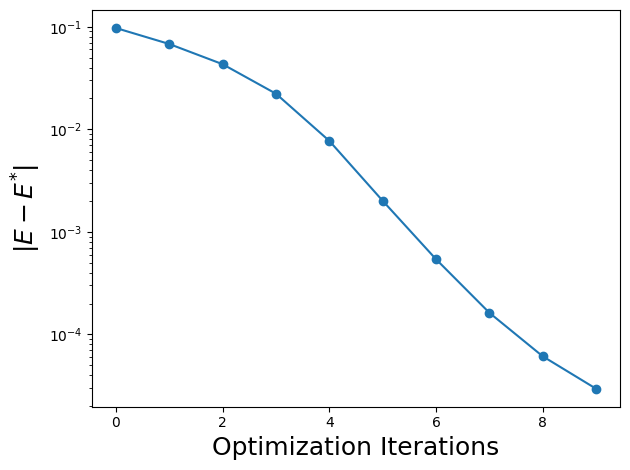

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(range(len(result.func_vals)),
             np.abs(np.array(result.func_vals) - energy(parameters)),
             'C0o-')
plt.xlabel("Optimization Iterations",  fontsize=18)
plt.ylabel(r"$|E  - E^{*}|$", fontsize=18)
plt.tight_layout()
plt.show()